# 输入数据编码
在人工神经网络（ANN）中，数据都是“模拟”的，是一个具体的数值。

对于脉冲神经网络（SNN），数据都是“数字”的，脉冲信号数据仅有2种状态：脉冲（为1），无脉冲（为0）。

所以，就让我们从如何将输入的数据编码为脉冲信号数据开始我们的学习吧。

一个最简单的脉冲数据编码方式就是设定一个阈值，当原始数据大于该阈值则编码为脉冲（1），否则不产生脉冲（0）。但是，这种方法的缺点很明显：原始数据的大小信息几乎全部丢失了。

为了保存原始数据的大小信息，一种可能的方法就是将原始信息的大小转化为产生脉冲的概率：如果原始数据比较大，那么就意味着该数据被编码为脉冲的概率较大，反之则概率较小。

如果我们只进行一次编码，我们其实并不能反映出来数据的概率。在实际情况中，我们会设定一个仿真周期`T`，独立重复的进行`T`次编码，才可以在仿真周期`T`中反映出概率。

惊蛰框架中的`spikingjelly.activation_based.encoding`中包含了编码的相关函数，这里我们使用*泊松编码器*进行讲解，读者也可以自行选择其他编码器。

泊松编码器的编码原理是：将输入的数据，映射到概率P，最终以概率P产生脉冲（1）。

在仿真周期T中，该数据产生脉冲的概率为P。回想概率论中的内容，该过程与泊松分布相同，这也是泊松编码器名字的由来。

以一个灰度图像数据为例，比如某个像素点的数据为100，由于灰度图像的像素值在[0, 255]，归一化后$100/255=0.39$，所以最终的概率P为0.39，那么该像素点有39%(0.39)的概率产生脉冲。

使用泊松编码之后的效果为：原始图像中数值较高的像素点，在仿真周期T中，产生脉冲的概率较高；而数值较低的像素点，产生脉冲的概率较低。

*注意：必须保证输入的数据处于[0 - 1]之间*

In [1]:
# import
import torch

from spikingjelly.activation_based import encoding

# 仿真周期
T = 10

# 随机生成一个处于[0-1]之间的数据x
x = torch.rand(1)
print(f"x = {x}")

# 配置编码器
encoder = encoding.PoissonEncoder()
x_encoded = torch.zeros(T)
# 重复进行T次编码
for t in range(T):
    x_encoded[t] = encoder(x)
print(f"x_encoded = {x_encoded}")

num = x_encoded.sum() # 将编码后的1相加
rate = num / T # 得到编码后的概率
print(f"rate = {rate: .4f}")

x = tensor([0.7226])
x_encoded = tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
rate =  0.9000


最终编码后的数据向量`x_encoded`中脉冲（1）的概率`rate`，和我们随机生成的原始数据`x`接近（如果相差较大，请多运行几次并观察结果），这就是代表：将x编码到时间周期T=10中。换句话说，在10个单位时间中出现脉冲（1）的概率为x。

让我们将仿真周期T增加为100.

In [2]:
# 仿真周期
T = 100 # 把仿真时间T增加到100

# 随机生成一个处于[0-1]之间的数据x
x = torch.rand(1)
print(f"x = {x}")

# 配置编码器
encoder = encoding.PoissonEncoder()
x_encoded = torch.zeros(T)  # 编码后的数据
for t in range(T):
    x_encoded[t] = encoder(x)
print(f"x_encoded = {x_encoded}")

num = x_encoded.sum() # 将编码后的1相加
rate = num / T # 得到编码后的概率
print(f"rate = {rate: .4f}")

x = tensor([0.9290])
x_encoded = tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
rate =  0.9400


可以看到，当我们将T从10增加到100，最终的概率与输入的x更接近。理论上，仿真周期T越大，输出的脉冲频率越接近实际输入值。当$T \rightarrow +\infty$，输出的脉冲频率越等于实际输入值。

但是，在实际的SNN中，我们通常并不会将T设置的非常大，因为最终的训练效果与T的大小并无直接关系，我们通常设置T为[10, 50]即可。

上面的例子只是一个简单的演示.接下来，让我们将输入的数据从单个数字推广到向量类型。

In [3]:
# 仿真周期
T = 20 # 把仿真时间T设置为20
size = 10 # 生成的数据大小为10

# 随机生成一个大小为[size]的数据x
x = torch.rand([size])
print(f"x = {x}")

# 配置编码器
encoder = encoding.PoissonEncoder()
x_encoded_size = [T, size] # 编码后的数据大小
x_encoded = torch.zeros(x_encoded_size) # 编码后的数据
# 开始按照时间逐步编码
for t in range(T):
    x_encoded[t] = encoder(x)
print(f"x_encoded = {x_encoded}")

num = x_encoded.sum(dim=0) # 将编码后的脉冲(1)按照维度0（时间维度）求和
rate = num / T # 得到编码后的概率
print(f"rate = {rate}")

x = tensor([0.4407, 0.2672, 0.5331, 0.7221, 0.4975, 0.5007, 0.5003, 0.0760, 0.8638,
        0.4385])
x_encoded = tensor([[1., 1., 0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 1., 0.],
        [1., 1., 1., 1., 0., 1., 0., 0., 0., 1.],
        [0., 1., 1., 1., 0., 0., 1., 0., 1., 0.],
        [0., 1., 1., 1., 1., 0., 0., 0., 1., 1.],
        [1., 0., 0., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 1., 0., 0., 0., 1., 1.],
        [0., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [1., 0., 1., 1., 1., 1., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
        [1., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1., 0., 

编码之后的输出是一个大小为[T, size]的矩阵，矩阵的每一行表示一个时刻,每一列表示单个数据编码后的结果。

趁热打铁，让我们将数据拓展为矩阵

In [4]:
T = 20 # 把仿真时间T设置为20
size = [5, 5] # 输入数据大小

# 随机生成一个大小为[size]的数据x
x = torch.rand(size)
print(f"x = {x}")

# 配置编码器
encoder = encoding.PoissonEncoder()
x_encoded_size = [T, size[0], size[1]] # 编码后的数据大小
x_encoded = torch.zeros(x_encoded_size) # 编码后的数据
# 开始按照时间逐步编码
for t in range(T):
    x_encoded[t] = encoder(x)

num = x_encoded.sum(dim=0) # 将编码后的脉冲(1)按照维度0（时间维度）求和
rate = num / T # 得到编码后的概率
print(f"rate = {rate}")

x = tensor([[0.1395, 0.6151, 0.0451, 0.3333, 0.1260],
        [0.1068, 0.9455, 0.4497, 0.4482, 0.4981],
        [0.7679, 0.1980, 0.8419, 0.6455, 0.8471],
        [0.5639, 0.2257, 0.2223, 0.8061, 0.9546],
        [0.2504, 0.4019, 0.5377, 0.1807, 0.2393]])
rate = tensor([[0.1000, 0.5000, 0.0500, 0.2500, 0.3000],
        [0.2500, 0.9500, 0.5500, 0.5000, 0.4500],
        [0.9500, 0.4500, 0.8000, 0.6500, 0.8500],
        [0.5000, 0.2500, 0.3000, 0.8000, 1.0000],
        [0.2500, 0.4500, 0.6000, 0.2500, 0.3000]])


最后，让我们将一个真实的MNIST数据集中的数据进行泊松编码，并查看效果。

In [5]:
# import
import torch.utils.data as data
import torchvision

from matplotlib import pyplot as plt

若报错`无法找到matplotlib`

请尝试在anaconda中重新安装`matplotlib`库

In [6]:
# 导入数据集
dataset_dir = "./dataset"
# 加载训练数据集
train_dataset = torchvision.datasets.MNIST(
    root=dataset_dir,
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)
# 加载测试数据集
test_dataset = torchvision.datasets.MNIST(
    root=dataset_dir,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

# 使用DataLoader加载训练数据
train_data_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)
# 使用DataLoader加载测试数据
test_data_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

原始图像
label: 7


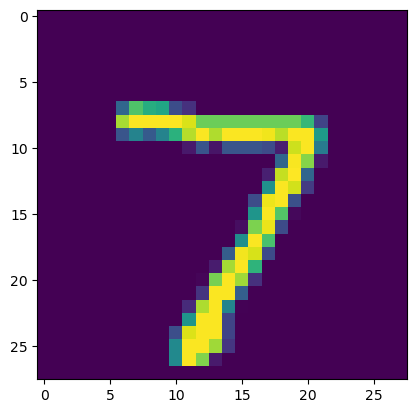

编码后输出图像


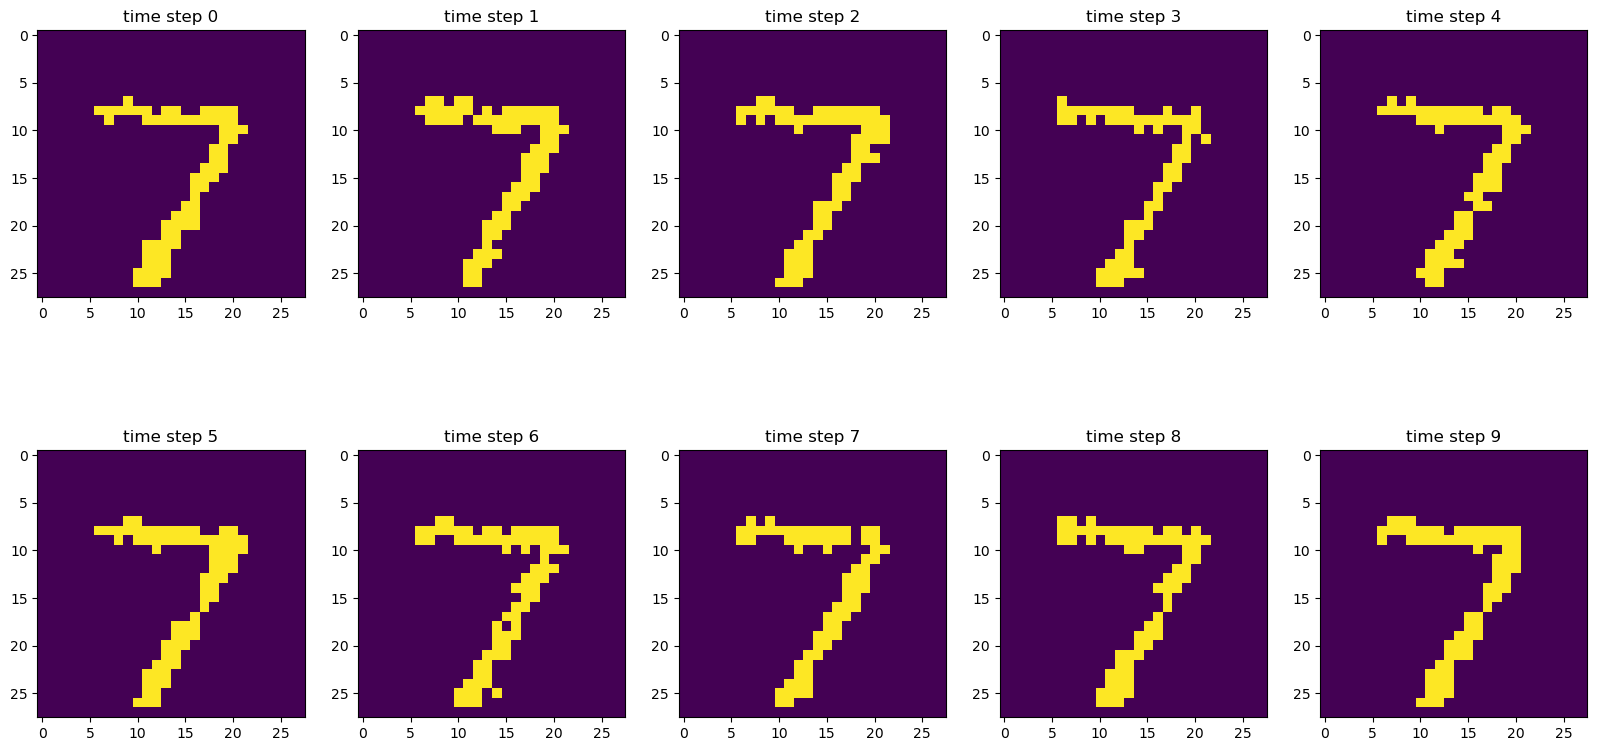

In [7]:
# 加载测试集中的单张图片
index = 0 # index要处于0-9999之间
input, label = test_dataset[index] # 加载数据集时的transform函数已经将数据归一化到[0, 1]范围内
input_IMG = torchvision.transforms.ToPILImage()(input)
plt.imshow(input_IMG)
print("原始图像")
print(f"label: {label}")
plt.show()

T = 10 # 把仿真时间T设置为10
# 配置编码器
encoder = encoding.PoissonEncoder()
x_encoded_size = [T, 28, 28] # 编码后的数据大小
x_encoded = torch.zeros(x_encoded_size) # 编码后的数据
# 开始按照时间逐步编码
plt.figure(figsize=(20, 10)) # 设置画图大小
print("编码后输出图像")
for t in range(T):
    x_encoded[t] = encoder(input)
    input_IMG = torchvision.transforms.ToPILImage()(x_encoded[t])
    plt.subplot(2, 5, t+1)
    plt.imshow(input_IMG)
    plt.title(f"time step {t}")
plt.show()

可以看到，在10个时间步长中，原始图像中数值比较高的（比较亮的）部分，比如“7”（index=0）的拐点处，在每一个时间步长中都输出脉冲。

而数值比较低的（比较暗的）部分，比如“7”的边缘处，则按照概率在每一个时间步长中输出脉冲。